# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

import ipywidgets as widgets
from matplotlib_venn import venn2

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import DataProject

# Read and clean data

In [3]:
return_to_schooling = 'Data_Return_To_Schooling.dta'
government_expenditure = 'Data_Government_Expenditues.dta'

rts = pd.read_stata(return_to_schooling)
rts.head(20)

,isoname,iso,coef_yrs,lb_yrs,ub_yrs,coef_yrl_pri,lb_yrl_pri,ub_yrl_pri,coef_yrl_sec,lb_yrl_sec,ub_yrl_sec,coef_yrl_ter,lb_yrl_ter,ub_yrl_ter,coef_yrs_sex_0,lb_yrs_sex_0,ub_yrs_sex_0,coef_yrs_sex_1,lb_yrs_sex_1,ub_yrs_sex_1
0,Afghanistan,AF,0.078479,0.074420,0.082538,0.040175,0.031511,0.048839,0.062402,0.054232,0.070572,0.177964,0.154125,0.201803,0.127591,0.119587,0.135595,0.067746,0.063563,0.071930
1,Albania,AL,0.034103,0.030818,0.037388,NaN,NaN,NaN,0.021534,0.017730,0.025338,0.034103,0.030818,0.037388,0.053004,0.046538,0.059470,0.028385,0.024602,0.032169
2,Armenia,AM,0.066927,0.059332,0.074522,NaN,NaN,NaN,0.024771,0.007015,0.042527,0.067733,0.060093,0.075373,0.073827,0.062884,0.084770,0.060598,0.050029,0.071168
3,Angola,AO,0.153423,0.150328,0.156519,0.095934,0.091950,0.099918,0.195988,0.190429,0.201547,0.350000,0.488480,0.549719,0.143991,0.139648,0.148334,0.161459,0.157057,0.165860
4,Argentina,AR,0.109306,0.106965,0.111646,0.052639,0.045884,0.059393,0.089981,0.086916,0.093045,0.179094,0.172236,0.185951,0.137261,0.132987,0.141534,0.089635,0.086896,0.092374
5,Austria,AT,0.156845,0.142581,0.171109,NaN,NaN,NaN,0.198092,0.164019,0.232164,0.119655,0.104175,0.135135,0.167299,0.145419,0.189179,0.147411,0.128854,0.165968
6,Australia,AU,0.132774,0.124014,0.141534,NaN,NaN,NaN,0.091755,0.071568,0.111941,0.143471,0.133035,0.153907,0.150021,0.137466,0.162576,0.117338,0.105180,0.129495
7,Azerbaijan,AZ,0.051337,0.032200,0.070475,NaN,NaN,NaN,NaN,NaN,NaN,0.051337,0.032200,0.070475,0.037557,0.004607,0.070508,0.061876,0.039588,0.084163
8,Bosnia and Herzegovina,BA,0.047536,0.038795,0.056277,0.040867,-0.001352,0.083086,0.024884,0.014065,0.035703,0.113761,0.092127,0.135395,0.049129,0.035926,0.062333,0.045492,0.034891,0.056094
9,Barbados,BB,0.106584,0.090328,0.122839,NaN,NaN,NaN,0.066897,0.041659,0.092135,0.126075,0.106551,0.145599,0.122232,0.098913,0.145552,0.090657,0.068287,0.113027


Import your data, either through an API or manually, and load it. 

## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

**Interactive plot** :

In [2]:
def plot_func():
    # Function that operates on data set
    pass

widgets.interact(plot_func, 
    # Let the widget interact with data through plot_func()    
); 


interactive(children=(Output(),), _dom_classes=('widget-interact',))

Explain what you see when moving elements of the interactive plot around. 

# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

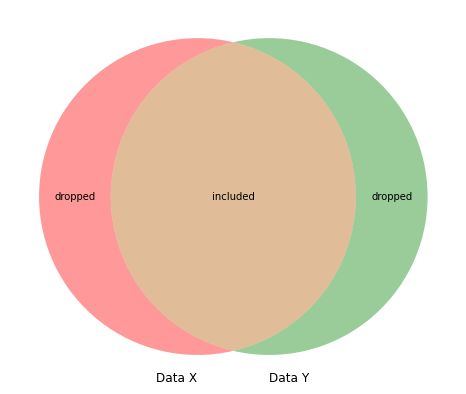

In [3]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('Data X', 'Data Y'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.